In [1]:
import pandas as pd 

df = pd.read_csv(r"..\artifacts\data_preprocessing\BRCA\ac_rule_1.tsv",sep="\t",header=None)
df.columns = ['class' , 'support', 'confidence' , 'antecedents', 'interestingness']


df.groupby(['class']).size().reset_index(name='ac_rules_counts') 

,class,ac_rules_counts
0,0.0,11771
1,1.0,7421
2,2.0,2801
3,3.0,1793
4,4.0,1667


In [2]:
print(df.head())

   class   support  confidence  \
0    0.0  0.970874    0.162602   
1    0.0  0.970874    0.162602   
2    0.0  0.970874    0.162602   
3    0.0  0.970874    0.162602   
4    0.0  0.970874    0.162602   

                                         antecedents  interestingness  
0  151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...        -0.099556  
1  151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...        -0.099639  
2  151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...        -0.099671  
3  151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...        -0.099704  
4  151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...        -0.099777  


In [3]:
df.groupby(['class']).apply(lambda x: x.nlargest(50 , 'interestingness')).reset_index(drop=True)

C:\Users\tchia\AppData\Local\Temp\ipykernel_14852\1879726690.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['class']).apply(lambda x: x.nlargest(50 , 'interestingness')).reset_index(drop=True)


,class,support,confidence,antecedents,interestingness
0,0.0,0.970874,0.162602,"151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...",-0.099556
1,0.0,0.970874,0.162602,"151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...",-0.099639
2,0.0,0.970874,0.162602,"151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...",-0.099671
3,0.0,0.970874,0.162602,"151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...",-0.099704
4,0.0,0.970874,0.162602,"151:0.0,62:0.0,971:0.0,114:0.0,95:0.0,112:0.0,...",-0.099777
...,...,...,...,...,...
245,4.0,0.896552,0.042276,"299:0.0,377:0.0,376:0.0,374:0.0,373:0.0,372:0....",-0.388491
246,4.0,0.965517,0.045528,"299:0.0,377:0.0,376:0.0,374:0.0,373:0.0,372:0....",-0.388505
247,4.0,0.896552,0.042276,"299:0.0,377:0.0,376:0.0,374:0.0,373:0.0,372:0....",-0.388505
248,4.0,0.896552,0.042276,"299:0.0,377:0.0,376:0.0,374:0.0,373:0.0,372:0....",-0.388506


In [8]:
import torch 
from tqdm import tqdm
from torch_geometric.data import Data , Batch
from itertools import combinations
import numpy as np


graphs = []

# select top 100 rules for each class with highest interestingness
df_filtered = df.groupby(['class']).apply(lambda x: x.nlargest(100, 'interestingness')).reset_index(drop=True)


with tqdm(total = df_filtered.shape[0]) as pbar:
    # [2 , num_edges]
    edges = [[] , []]

    # [ num_nodes , num_node_features ]
    features = []
    
    for index , row in df_filtered.iterrows():
        node_idx = [int(x.split(":")[0]) for x  in row['antecedents'].split(',')]
        node_features = [float(x.split(":")[1]) for x  in row['antecedents'].split(',')]
        # print(node_idx)
        # print(node_features)
        # print(row['class'])
        
        edge_tensor = torch.tensor([x for x in combinations(node_idx , 2)] , dtype=torch.long) # shape => [num_edges , 2]
        # reshape to [ 2, num_edges]
        edge_tensor = edge_tensor.reshape(2 , -1)
        
        features_tensor = torch.tensor(node_features , dtype=torch.float32).reshape(-1 , 1)
        
        graph = Data(edge_index=edge_tensor , y=torch.tensor([row['class']]), x=torch.tensor([1]))
        
        graphs.append(graph)
        pbar.update(1)

C:\Users\tchia\AppData\Local\Temp\ipykernel_19512\2312865802.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby(['class']).apply(lambda x: x.nlargest(100, 'interestingness')).reset_index(drop=True)
100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


In [9]:
batch = Batch.from_data_list(graphs)

In [10]:
with open(r"..\artifacts\data_preprocessing\BRCA\graph.pt" , 'wb') as f:
    torch.save(batch , f)

In [11]:
import torch.nn.functional as F
from torch_geometric.nn import ARGA
from torch_geometric.utils import train_test_split_edges

class ARGAWrapper(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ARGAWrapper, self).__init__()
        self.model = ARGA(in_channels, hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        return self.model(x, edge_index, edge_attr)

In [14]:
model = ARGAWrapper(in_channels=1, 
                    hidden_channels=64, 
                    out_channels=1)


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ValueError: optimizer got an empty parameter list

In [21]:
import itertools
# select top 100 rules for each class with highest interestingness
df_filtered = df.groupby(['class']).apply(lambda x: x.nlargest(1000, 'interestingness')).reset_index(drop=True)

adjacancy_matrix = torch.zeros(1000 , 1000)
with tqdm(total = df_filtered.shape[0]) as pbar:
    for index , row in df_filtered.iterrows():
        node_idx = [int(x.split(":")[0]) for x  in row['antecedents'].split(',')]
        
        vector_idx = np.array([x for x in itertools.combinations(node_idx , 2)])
        adjacancy_matrix[vector_idx[:,0] , vector_idx[:,1]] += 1
        adjacancy_matrix[vector_idx[:,1] , vector_idx[:,0]] += 1 # it is undirected graph
        
        pbar.update(1)

C:\Users\tchia\AppData\Local\Temp\ipykernel_19512\3487998566.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby(['class']).apply(lambda x: x.nlargest(1000, 'interestingness')).reset_index(drop=True)
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [08:00<00:00, 10.40it/s]


<Axes: >

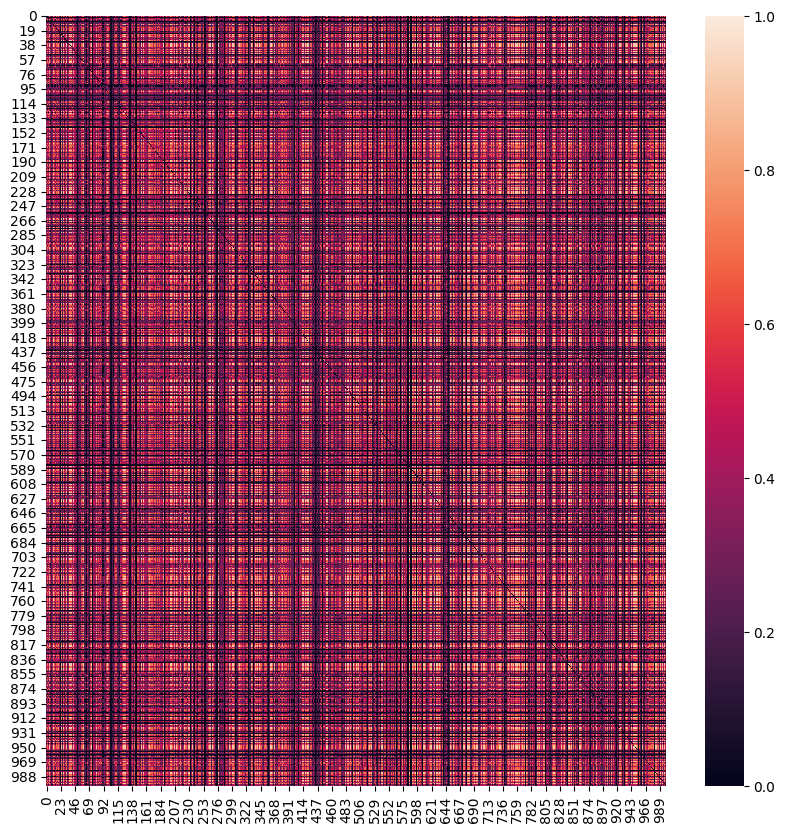

In [23]:
# plot the adjacancy matrix as heatmap 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# normalize the adjacancy matrix
normalize_adjacancy_matrix = adjacancy_matrix / adjacancy_matrix.max()
sns.heatmap(normalize_adjacancy_matrix.numpy())

In [31]:
df_features = pd.read_csv(r"..\artifacts\data_preprocessing\BRCA\1_tr.csv",header=None)

In [30]:
# convert edge_matrix to edge_index
edge_index = torch.tensor(np.where(normalize_adjacancy_matrix > 0) , dtype=torch.long)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.001058,0.002864,0.005178,0.001796,0.004143,0.005765,0.000960,0.016912,0.002427,0.000204,...,0.000453,0.000353,0.000031,0.000568,0.000119,0.001608,0.000155,0.000053,0.001128,0.004402
1,0.001647,0.003474,0.002605,0.000379,0.001028,0.001997,0.000395,0.007749,0.003168,0.000281,...,0.001020,0.000219,0.000108,0.002113,0.000047,0.001217,0.000013,0.000178,0.000630,0.000496
2,0.006563,0.004372,0.003259,0.001344,0.000904,0.002104,0.000495,0.007030,0.003846,0.000143,...,0.000886,0.000238,0.000041,0.000426,0.000006,0.008201,0.000028,0.000034,0.001102,0.000686
3,0.007797,0.006315,0.004806,0.001511,0.000787,0.003202,0.000900,0.006007,0.002961,0.000478,...,0.000764,0.000430,0.000022,0.000164,0.000004,0.002834,0.000105,0.000373,0.001031,0.002329
4,0.000442,0.007653,0.005326,0.000649,0.001268,0.006589,0.001170,0.010095,0.003134,0.000374,...,0.000875,0.000844,0.000011,0.000033,0.000040,0.002301,0.000159,0.000501,0.000760,0.002547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.001898,0.003215,0.004471,0.001760,0.000843,0.005589,0.000648,0.010275,0.005172,0.000251,...,0.000433,0.000442,0.000011,0.000109,0.000006,0.002219,0.000063,0.000084,0.001083,0.003269
150,0.000256,0.009275,0.004186,0.000070,0.001805,0.004607,0.001104,0.020653,0.002920,0.000745,...,0.001891,0.000609,0.000141,0.001068,0.000329,0.000418,0.000629,0.000568,0.001442,0.002915
151,0.002392,0.004421,0.003907,0.000591,0.001062,0.002516,0.000634,0.006137,0.002710,0.000234,...,0.000928,0.000079,0.000059,0.001353,0.000024,0.002695,0.000009,0.000153,0.000939,0.000751
152,0.000455,0.005294,0.004045,0.000226,0.000710,0.003422,0.001887,0.014374,0.001586,0.000431,...,0.002763,0.000234,0.000137,0.000953,0.000105,0.000520,0.000477,0.000555,0.003736,0.001125


In [52]:
import torch_geometric.utils as geom_utils
def coo_to_pyg_data(coo_matrix , node_features ):
    values = torch.FloatTensor(coo_matrix.data).unsqueeze(1)
    indices = torch.LongTensor(np.vstack((coo_matrix.row, coo_matrix.col)))
    size = torch.Size(coo_matrix.shape)

    indices , values = geom_utils.to_undirected(indices , values)
    
    return Data(x=node_features, edge_index=indices, edge_attr=values, num_nodes=size[0])

In [34]:
from scipy.sparse import coo_matrix
def symmetric_matrix_to_coo(matrix , threshold):
    # Find the nonzero entries in the upper triangle (including the main diagonal)
    rows, cols = np.triu_indices_from(matrix, k=0)

    # Extract the corresponding values from the upper triangle
    data = matrix[rows, cols]

    # Filter entries based on the threshold
    mask = data >= threshold
    rows = rows[mask]
    cols = cols[mask]
    data = data[mask]
    
    # Create a COO matrix
    coo = coo_matrix((data, (rows, cols)), shape=matrix.shape)

    return coo

In [36]:
edge_coo = symmetric_matrix_to_coo(normalize_adjacancy_matrix.numpy() , 0.5)

In [113]:
data = coo_to_pyg_data(edge_coo , torch.tensor(df_features.T.values, dtype=torch.float32))

In [108]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

In [114]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

c:\Users\tchia\miniconda3\envs\gnn\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[1000, 615], num_nodes=1000, val_pos_edge_index=[2, 5387], val_pos_edge_attr=[5387, 1], test_pos_edge_index=[2, 10775], test_pos_edge_attr=[10775, 1], train_pos_edge_index=[2, 183178], train_pos_edge_attr=[183178, 1], train_neg_adj_mask=[1000, 1000], val_neg_edge_index=[2, 5387], test_neg_edge_index=[2, 10775])

In [119]:
num_nodes = data.num_nodes

class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
    
def train():
    model.train()
    encoder_optimizer.zero_grad()
    
    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)  
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
 
    loss = 0
    loss = loss + model.reg_loss(z)  # Comment
    
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()
    
    return loss

@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    # kmeans_input = z.cpu().numpy()
    # kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    # pred = kmeans.predict(kmeans_input)

    # labels = data.y.cpu().numpy()
    # completeness = completeness_score(labels, pred)
    # hm = homogeneity_score(labels, pred)
    # nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc , ap #, completeness, hm, nmi

latent_size = 128
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=256, 
                              out_channels=1) # Comment

model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

for epoch in range(1, 201):
    loss = train()
    auc, ap = test()
    # print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
    #        f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
    #        f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}'))

Epoch: 001, Loss: 10.721, AUC: 0.640, AP: 0.520
Epoch: 002, Loss: 10.672, AUC: 0.640, AP: 0.520
Epoch: 003, Loss: 10.717, AUC: 0.640, AP: 0.520
Epoch: 004, Loss: 10.842, AUC: 0.640, AP: 0.520
Epoch: 005, Loss: 10.778, AUC: 0.640, AP: 0.520
Epoch: 006, Loss: 10.772, AUC: 0.640, AP: 0.520
Epoch: 007, Loss: 10.700, AUC: 0.640, AP: 0.520
Epoch: 008, Loss: 10.666, AUC: 0.640, AP: 0.520
Epoch: 009, Loss: 10.688, AUC: 0.640, AP: 0.520
Epoch: 010, Loss: 10.709, AUC: 0.640, AP: 0.520
Epoch: 011, Loss: 10.720, AUC: 0.640, AP: 0.520
Epoch: 012, Loss: 10.777, AUC: 0.640, AP: 0.520
Epoch: 013, Loss: 10.729, AUC: 0.640, AP: 0.520
Epoch: 014, Loss: 10.696, AUC: 0.640, AP: 0.520
Epoch: 015, Loss: 10.823, AUC: 0.640, AP: 0.520
Epoch: 016, Loss: 10.628, AUC: 0.640, AP: 0.520
Epoch: 017, Loss: 10.831, AUC: 0.640, AP: 0.520
Epoch: 018, Loss: 10.753, AUC: 0.640, AP: 0.520
Epoch: 019, Loss: 10.746, AUC: 0.640, AP: 0.520
Epoch: 020, Loss: 10.681, AUC: 0.640, AP: 0.520
Epoch: 021, Loss: 10.752, AUC: 0.640, AP

KeyboardInterrupt: 

In [126]:
from torch_geometric.nn import GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.mask = torch
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# parameters
out_channels = 16
num_features = data.x.shape[1]
epochs = 200

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))


Epoch: 001, AUC: 0.7226, AP: 0.5864
Epoch: 002, AUC: 0.8115, AP: 0.6991
Epoch: 003, AUC: 0.8273, AP: 0.7543
Epoch: 004, AUC: 0.8336, AP: 0.7746
Epoch: 005, AUC: 0.8392, AP: 0.7839
Epoch: 006, AUC: 0.8413, AP: 0.7900
Epoch: 007, AUC: 0.8378, AP: 0.7878
Epoch: 008, AUC: 0.8217, AP: 0.7702
Epoch: 009, AUC: 0.8031, AP: 0.7464
Epoch: 010, AUC: 0.7868, AP: 0.7225
Epoch: 011, AUC: 0.7830, AP: 0.7148
Epoch: 012, AUC: 0.7931, AP: 0.7241
Epoch: 013, AUC: 0.8087, AP: 0.7387
Epoch: 014, AUC: 0.8345, AP: 0.7635
Epoch: 015, AUC: 0.8633, AP: 0.7942
Epoch: 016, AUC: 0.8849, AP: 0.8169
Epoch: 017, AUC: 0.8989, AP: 0.8311
Epoch: 018, AUC: 0.9049, AP: 0.8365
Epoch: 019, AUC: 0.9076, AP: 0.8406
Epoch: 020, AUC: 0.9083, AP: 0.8411
Epoch: 021, AUC: 0.9069, AP: 0.8369
Epoch: 022, AUC: 0.9050, AP: 0.8307
Epoch: 023, AUC: 0.9056, AP: 0.8298
Epoch: 024, AUC: 0.9069, AP: 0.8304
Epoch: 025, AUC: 0.9103, AP: 0.8329
Epoch: 026, AUC: 0.9131, AP: 0.8362
Epoch: 027, AUC: 0.9175, AP: 0.8444
Epoch: 028, AUC: 0.9238, AP:

In [127]:
def get_node_embeddings(data, model):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return z.cpu().numpy()

In [133]:
z = get_node_embeddings(data , model)

(1000, 16)
